In [1]:
import sys
sys.path.append('/hdd/si_han/Tools/python_modules/')
sys.path.insert(1,'/hdd/si_han/cpptraj_test/pytraj') 

import pytraj as pt
from sklearn.decomposition import PCA
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from interpolateCurve import interpolateCurve
from log_progress import*
from LineBuilder import*

In [2]:
def findnorm(fp):
    slope = np.array([[None]*len(fp)],dtype=float).reshape(len(fp),1)
    for i in range(len(fp)-1):
        #sign = 1 if fp[i+1,0] - fp[i,0]>0 else -1
        slope[i] = -(fp[i+1,0] - fp[i,0])/(fp[i+1,1] - fp[i,1])
    slope[-1]=slope[-2]
    return slope

In [3]:
def Project(P, M, P1):
    PM_x = P[0]-M[0]
    PM_y = P[1]-M[1]
    P1M_x = P1[0]-M[0]
    P1M_y = P1[1]-M[1]
    L = P1M_x*P1M_x + P1M_y*P1M_y
    p = PM_x*P1M_x + PM_y*P1M_y
    pp_x = M[0] + p/L*P1M_x
    pp_y = M[1] + p/L*P1M_y
    return np.array([pp_x, pp_y])

In [4]:
def OptMileStone(x, y, xp, yp, xn, yn, slopeopt, step=0.05, niter=20):
    pd1, pd2 = [np.array([0.0]*len(slopeopt)*2).reshape(len(slopeopt),2) for i in range(2)]
    for j in range(niter):
        for i in range(1,len(slopeopt)):
            d1 = (xp[i] - xp[i-1])**2 + (yp[i] - yp[i-1])**2
            d2 = (xn[i] - xp[i-1])**2 + (yn[i] - yp[i-1])**2
            if d1>d2:
                tmpx, tmpy = [xp[i], yp[i]]
                xp[i], yp[i] = [xn[i], yn[i]]
                xn[i], yn[i] = [tmpx, tmpy]
        for i in range(1,len(slopeopt)-1):
            ip1 = max(i-1, 0)
            ip2 = min(i+1, len(slopeopt))
            pp11 = Project([xp[i],yp[i]], [xp[ip1],yp[ip1]], [x[ip1],y[ip1]])
            pp12 = Project([xp[i],yp[i]], [xp[ip2],yp[ip2]], [x[ip2],y[ip2]])
            pp21 = Project([xn[i],yn[i]], [xn[ip1],yn[ip1]], [x[ip1],y[ip1]])
            pp22 = Project([xn[i],yn[i]], [xn[ip2],yn[ip2]], [x[ip2],y[ip2]])
            mid1_x, mid1_y = [(pp11[j]+pp12[j])/2 for j in range(2)]
            mid2_x, mid2_y = [(pp21[j]+pp22[j])/2 for j in range(2)]
            pd1[i,0], pd1[i,1] = [(mid1_x-xp[i])*step, (mid1_y-yp[i])*step ]
            pd2[i,0], pd2[i,1] = [(mid2_x-xn[i])*step, (mid2_y-yn[i])*step ]
            
        pd1[0,0], pd1[0,1] = [pd1[1,0], pd1[1,1]]
        pd2[0,0], pd2[0,1] = [pd2[1,0], pd2[1,1]]
        xp += pd1[:,0].reshape(len(xp),1)
        yp += pd1[:,1].reshape(len(xp),1)
        xn += pd2[:,0].reshape(len(xp),1)
        yn += pd2[:,1].reshape(len(xp),1)
    
    # slope array N*1
    global slope_opt 
    slope_opt = (yp-y)/(xp-x)

In [5]:
## correct (Xp, Yp) and (Xn, Yn)
def CorrectXYnp(Xp,Yp,Xn,Yn):
    for i in range(1,len(slope_opt)):
        d1 = (Xp[i] - Xp[i-1])**2 + (Yp[i] - Yp[i-1])**2
        d2 = (Xn[i] - Xp[i-1])**2 + (Yn[i] - Yp[i-1])**2
        d3 = (Xn[i] - Xn[i-1])**2 + (Yn[i] - Yn[i-1])**2
        d4 = (Xp[i] - Xn[i-1])**2 + (Yp[i] - Yn[i-1])**2
#         if d1>d2:
        if max(d2,d4) < max(d1,d3):
            tmpx, tmpy = [Xp[i].copy(), Yp[i].copy()]
            tmpx1, tmpy1 = [Xn[i].copy(), Yn[i].copy()]
            Xp[i], Yp[i], Xn[i], Yn[i] = [tmpx1, tmpy1, tmpx, tmpy]

In [6]:
# rotation matrix from each milestone to x-axis
def RotationMatrix(Xp,Yp,X,Y,r):
    RotM = []
    vec0 = np.array([1,0])
    for i in range(len(X)):
        vec1 = np.array([Xp[i]-X[i], Yp[i]-Y[i]])
        theta = np.arccos( np.dot(vec1.T, vec0)/r )
        if vec1[1]<0:
            theta = 2*np.pi-theta

        c, s = [np.cos(theta), np.sin(theta)]
        rot = np.array([[c, s],[-s, c]]).reshape(2,2)
        RotM.append(rot)
    RotM = np.asarray(RotM)
    
    return(RotM)

# 1. Obtaining milestones from biased MD or PSIM

## 1.1 Load metadynamics/PSIM trajectories to the notebook
In order to project high dimensional trajectories into low dimensional spaces, we start by loading the Cartesian coordinates of protein and ligand using pytraj.

In [10]:
# specify path of promtop and dcd files
reaction_path = '/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory'
TOP = reaction_path+'/complex.prmtop'
TRAJ = reaction_path+'/nowater.dcd'

# read the trajecory from the disk
traj = pt.iterload(TRAJ, TOP,stride=1)

## 1.2 Align the trajectory to a reference frame
We next remove rotation and translation of the protein by aligning the protein to a reference frame. We used atomic masks to specify atoms used for alignment. In this case, we used all the backbone atoms of the CDK8 protein (residues 1-359) to perform alignment. 

In [11]:
# superpose to the reference of the original trajectory
refpdb = pt.load(reaction_path+'/0.pdb')
pt.superpose(traj, ref=refpdb, mask='(:1-359)&(@N,@C,@CA,@O)')

pytraj.TrajectoryIterator, 5455 frames: 
Size: 1.260987 (GB)
<Topology: 10342 atoms, 620 residues, 3 mols, non-PBC>
           

## 1.3 Reading trajectories ...
Now we need to extract the Cartesian coordinates from the trajectory, which will be used as high-d representations of the trajectory. Here, the selected Cartesian coordiates include all the alphe carbon atoms of proteins and all the heavy atoms of the ligand.  

In [14]:
# use ".xyz" attribute to print the Cartesian coordinates of the first frame
traj[:1].xyz

array([[[-19.40857793,  26.06932418,   4.29338739],
        [-19.66818952,  25.15431127,   4.74369764],
        [-19.92913749,  26.34724487,   3.43053327],
        ...,
        [  2.66375547,   0.21173051,  -9.20354013],
        [  3.07702957,  -0.19314785,  -7.15747554],
        [  4.1288673 ,  -0.53416083,  -7.33470137]]])

We will store the Cartesian coordinates in a matrix, whose dimension is num_frames*(3*num_select_atoms) since there are x, y, and z coordinates of each atom.

In [16]:
# read the trajectory into memory by chunk
nframe = traj.n_frames
chunksize = min([200, nframe])
nchunk = int(np.floor(nframe/chunksize))+1 if nframe%chunksize !=0 else int(np.floor(nframe/chunksize))
pile = []
for i in log_progress(range(nchunk), every=1):
    tmp = traj[i*chunksize:min((i+1)*chunksize, nframe)]['@CA,:620']['!@H*']
    pile.append(tmp.xyz.reshape(tmp.n_frames, tmp.n_atoms*3))
    
proteinUNK_2d = np.concatenate(pile,axis=0)

In [17]:
proteinUNK_2d.shape

(5455, 1953)

## 1.4 Principal Component Analysis
Center the Cartesion coordinate matrix before performing PCA

In [21]:
proteinUNK_2d = proteinUNK_2d - proteinUNK_2d.mean(axis=0)

Peform PCA: here we only generate the first two PCs by setting n_components=2

In [19]:
# PCA using sklearn
pca = PCA(n_components=2)
reduced_cartesian = pca.fit_transform(proteinUNK_2d)
print(reduced_cartesian.shape)

# obtain eigvals and eigvecs
eigvals = pca.explained_variance_ratio_
eigvecs = pca.components_.T

(5455, 2)


In [27]:
# check the ratio of explained variance 
sum(pca.explained_variance_ratio_)

0.7961944421488383

## 1.5 Visualize PCs of the reaction

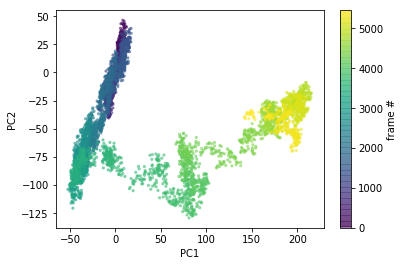

In [22]:
# set the first frame of the trajectory as an origin
refframe =  proteinUNK_2d[0,:].copy()
proteinUNK_ref_2d = proteinUNK_2d - refframe

# project high-d Cartesian coordinates into low-d PCs
projections=np.concatenate((np.dot(proteinUNK_ref_2d, eigvecs[:,0]).reshape(len(proteinUNK_ref_2d),1),
                            np.dot(proteinUNK_ref_2d, eigvecs[:,1]).reshape(len(proteinUNK_ref_2d),1)),
                           axis=1)
# plot results
plt.figure()
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5,
        c=range(int(len(proteinUNK_2d))),
        alpha=0.5
        )
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('frame #')

## 1.6 Obtain final reaction path

### 1.6.1 Generate smooth trajectory
We then use the low-d projections to sketch a reaction coordinate. A smooth path is generated by averaging frames in the before and after 100 steps of each frame,

In [23]:
smoothpath=[]
for i in range(len(projections)):
    istart=max(0,i-100)
    iend=min(len(projections)-1,i+100)
    smoothpath.append(projections[istart:iend].mean(axis=0))
smoothpath=np.asarray(smoothpath)

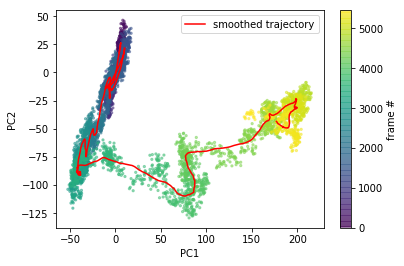

In [24]:
Fig=plt.figure()
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5,
        c=range(int(len(proteinUNK_2d))),
        alpha=0.5
        )
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('frame #')

plt.plot(smoothpath[:,0],smoothpath[:,1],
            color='r',label='smoothed trajectory')
plt.legend()
plt.show()

### 1.6.2 Detemine reaction path
Next, we are going to use a interactive tool to refine the reactioon path by avoiding the convoluted loops. Note that we call the interactive ploting interface using "matplotlib notebbok". However, sometimes it takes multiple tries to activate the interactive interface. Once the drawing panel comes up, use your mouse to move the cruiser, and left click to add green point along the smooth path. Note that all the convoluted loops should be escape. Once finished, move one to the next cell.

<IPython.core.display.Javascript object>


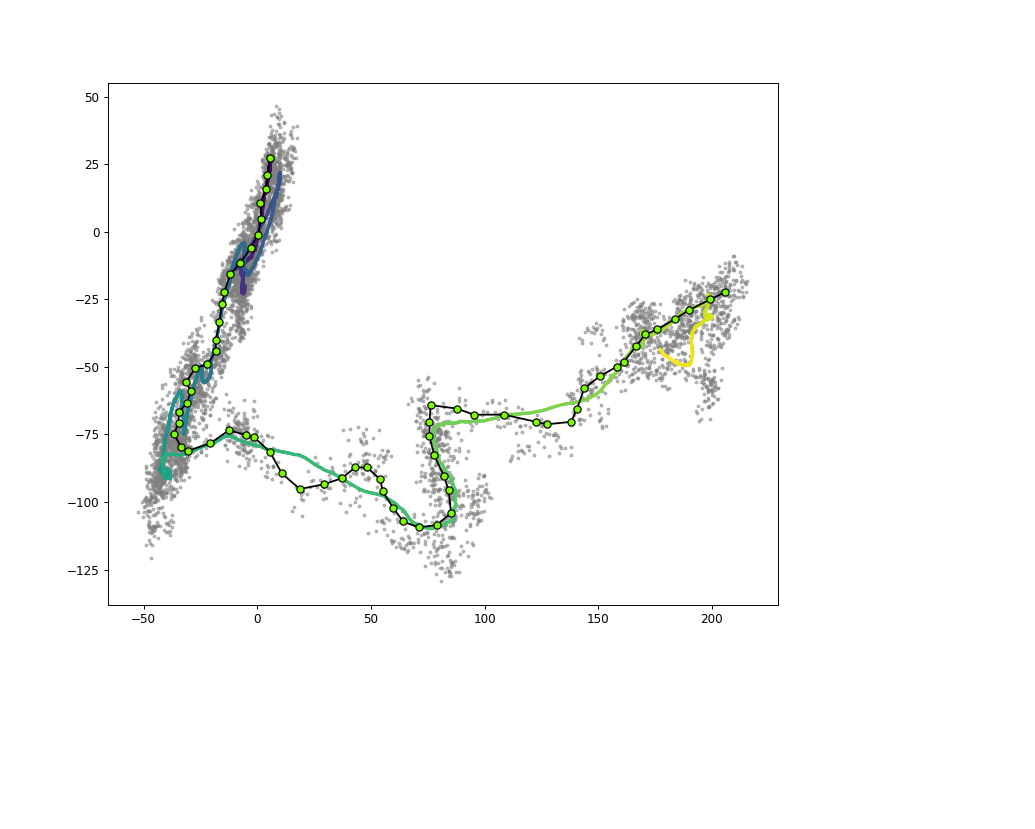

In [31]:
%matplotlib notebook
 
fig = plt.figure(figsize=(10,8))
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5, c='gray',
        alpha=0.5, zorder=0
        )
plt.scatter(smoothpath[:,0],smoothpath[:,1],s=3,
            c=range(int(len(proteinUNK_2d))),
            label='smoothed trajectory',
            zorder=5
           )
line, = plt.plot([], [],marker='o',color='k',markerfacecolor='lawngreen', zorder=10)  # empty line
linebuilder = LineBuilder(line)
plt.show()

In [34]:
#save temporary path
%matplotlib inline
path_id = 0  # specify which path you want to write/load
milestone_path=reaction_path+'/Milestone_%d'%path_id
%mkdir {milestone_path}

x1 = np.array([linebuilder.xs]).T
x2 = np.array([linebuilder.ys]).T
idx = np.array([range(len(x1))]).T
path_noloop = np.hstack((idx,x1))
path_noloop = np.hstack((path_noloop,x2))

#write path to temppath.txt
test = open(milestone_path+'/temppath.txt', "w+")
for i in range(len(path_noloop)):
    print("%s\t%s\t%s" %(i,path_noloop[i,1],path_noloop[i,2]), file=test)
test.close()

path_noloop = np.asarray( pd.read_csv(milestone_path+'/temppath.txt', header=None, delimiter=r"\s+") )

mkdir: cannot create directory ‘/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory/Milestone_0’: File exists


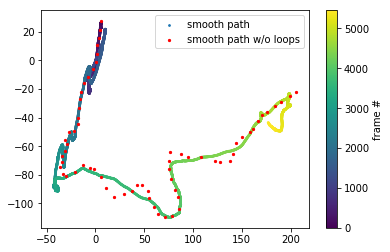

In [39]:
%matplotlib inline

fig = plt.figure()
plt.scatter(smoothpath[:,0],smoothpath[:,1],s=3,
            c=range(int(len(proteinUNK_2d))),label='smooth path')
cbar = plt.colorbar()
cbar.set_label('frame #')

plt.scatter(path_noloop[:,1],path_noloop[:,2],s=5,c='r', label='smooth path w/o loops')
plt.legend()
plt.show()

### 1.6.3 Path Interpolation
Now we have generated a few nodes along the smooth path, but the interval between nodes are still quite large. We use spline interpolation to connect nodes and generate a final smooth path w/o loops.

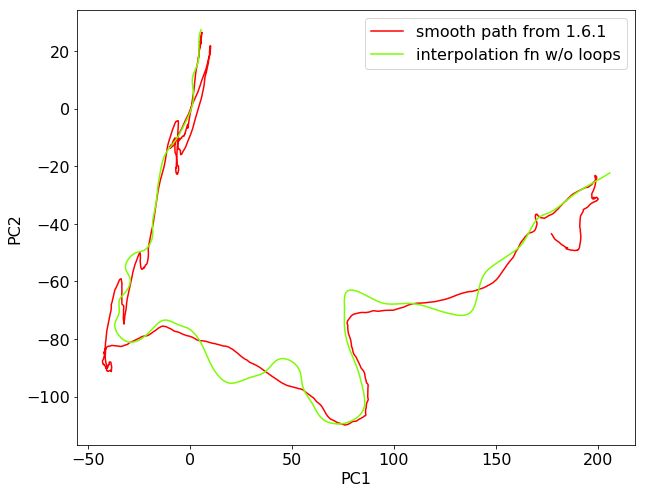

In [41]:
#path interpolation
%matplotlib inline
finalpath = interpolateCurve(np.asarray(path_noloop),500)
plt.figure(figsize=(10,8))
plt.plot(smoothpath[:,0],smoothpath[:,1],
        color='r',label='smooth path from 1.6.1')
plt.plot(finalpath[:,0],finalpath[:,1],
         color='lawngreen',label='interpolation fn w/o loops') #interpolation fn
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

### 1.6.4 Fine tune the final path
By default, the interpolated smooth curve contains 500 points, we select one of every n_milestone points as a center of milestones 

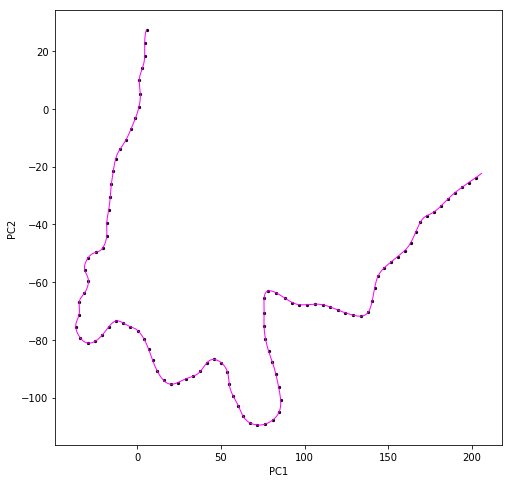

In [42]:
n_milestone = 5
fp = finalpath[::n_milestone]

finalpath = interpolateCurve(np.asarray(path_noloop),500)
plt.figure(figsize=(8,8))
plt.scatter(fp[:,0],fp[:,1],marker='o',s=5,c='k') #dots
plt.plot(finalpath[:,0],finalpath[:,1],color='magenta',linewidth=1) #interpolation fn
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Save the centers of milestones as finalpath.txt. You run this cell "ONLY" when the you create the center of the milestones. If you've already generated the finalpath.txt previously, then skip this cell.

In [43]:
file = open(milestone_path+'/finalpath.txt', "w+")
for i in range(len(fp)):
    print("%s\t%s\t%s" %(i,fp[i,0],fp[i,1]), file=file)
file.close()

Load the saved finalpath.txt

In [44]:
path = pd.read_csv(milestone_path+'/finalpath.txt', header=None, delimiter=r"\s+")
fp = np.asarray(path)
fp = fp[:,1:3]
fp.shape

(100, 2)

#### Now let's put everything we've worked out so far together. The percentage in the plotting panel is the ratio of variance explained by PC1 and PC2.

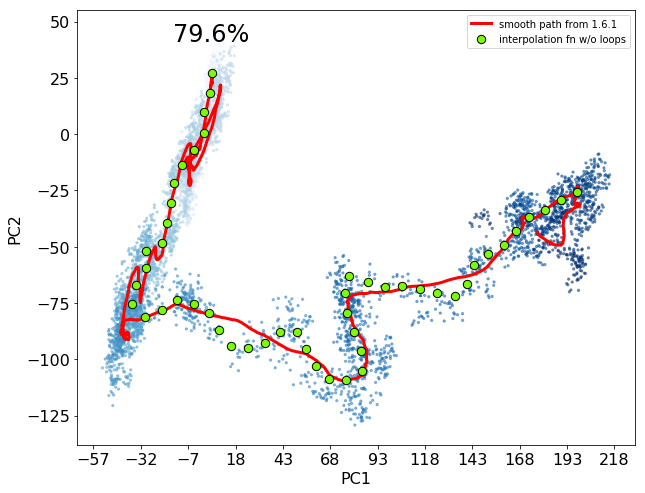

In [45]:
sum_var = sum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5,
        c=range(int(len(proteinUNK_2d))),
        alpha=0.5, zorder=0, cmap='Blues'
        )
# plt.blue()

plt.plot(smoothpath[:,0],smoothpath[:,1],linewidth=3,
        color='r',label='smooth path from 1.6.1', zorder=5)

plt.scatter(fp[::2,0],fp[::2,1],
         c='lawngreen',s=70,
        edgecolor='k',label='interpolation fn w/o loops',zorder=10) #interpolation fn

plt.annotate(s="%.1f"%(sum_var*100)+'%',
             xy=(-15,max(projections[:,1])-5),
             **dict(size=24, color='k'))
ax.set_xticks(range(int(min(projections[:,0]))-5, int(max(projections[:,0]))+5, 25))

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

## 1.7 Find initial milestones as a norm of the smoothed path
Initially, milestone lines are simply vertical lines with length = sc along the final smooth path. Without furthur optimization, several milestone lines overlap.

In [46]:
# generate norms along the path
slope = findnorm(fp)
slope_opt = np.empty_like(slope)
slope_opt[:]=slope

# radiaus = sc/2
sc = 20 

# coordinates of milestones on the path
X = fp[:,0].reshape(len(fp),1)
Y = fp[:,1].reshape(len(fp),1)

# slope matrix NxN
M = np.zeros((len(slope_opt),len(slope_opt)))
np.fill_diagonal(M,slope_opt)

# boundary of milestones in x-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_opt**2)).reshape(len(fp),1)
Xp = X + dX
Xn = X - dX

# boundary of milestones in y-axis Nx1
Yp = Y + np.dot(M,dX)
Yn = Y - np.dot(M,dX)
CorrectXYnp(Xp,Yp,Xn,Yn)

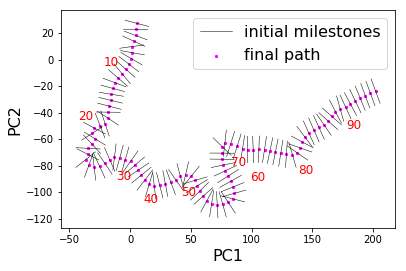

In [48]:
plt.figure()
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

## 1.8 Optimize the slopes of the milestones to minimize overlapping

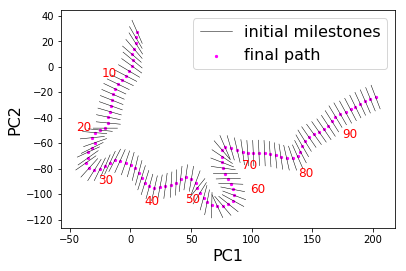

In [168]:
# Optimizing slopes of the milestones
OptMileStone(X,Y,Xp,Yp,Xn,Yn,slope_opt,0.05,3)

############ additional fix (optional) ##############
# for i in range(48,49):
#     slope_opt[i] *= 0.9

#slope matrix NxN
M = np.zeros((len(slope_opt),len(slope_opt)))
np.fill_diagonal(M,slope_opt)
# boundary of milestones in x-axis and y-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_opt**2))
Xp, Xn = [X + dX, X - dX]
Yp, Yn = [Y + np.dot(M,dX), Y - np.dot(M,dX)]

CorrectXYnp(Xp,Yp,Xn,Yn)
if (X[1]-X[0] > 0 and Yp[0]-Y[0]<0) or (X[1]-X[0] < 0 and Yp[0]-Y[0]>0):
    A, B = [Xp.copy(), Yp.copy()]
    C, D = [Xn.copy(), Yn.copy()]
    Xp, Yp, Xn, Yn = [C, D, A, B]
    
# Plot adjusted milestones   
plt.figure()
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

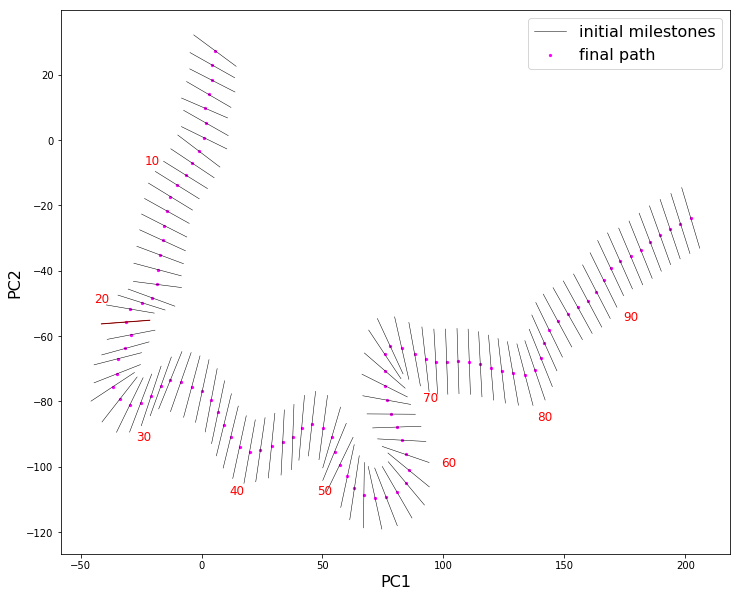

In [232]:
########### additional fix (optional) ##############

ini, fin = [21,22]

for i in range(ini, fin):
    slope_opt[i] *= 0.9 

#slope matrix NxN
M = np.zeros((len(slope_opt),len(slope_opt)))
np.fill_diagonal(M,slope_opt)
# boundary of milestones in x-axis and y-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_opt**2))
Xp, Xn = [X + dX, X - dX]
Yp, Yn = [Y + np.dot(M,dX), Y - np.dot(M,dX)]

CorrectXYnp(Xp,Yp,Xn,Yn)
if (X[1]-X[0] > 0 and Yp[0]-Y[0]<0) or (X[1]-X[0] < 0 and Yp[0]-Y[0]>0):
    A, B = [Xp.copy(), Yp.copy()]
    C, D = [Xn.copy(), Yn.copy()]
    Xp, Yp, Xn, Yn = [C, D, A, B]
    
# Plot adjusted milestones   
plt.figure(figsize=(12,10))
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(ini, fin):
    plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='r', linewidth=1, zorder=2)

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

Once you are satisfied with the milestone lines, save the slopes of each milestone in milestone_slopes.npy. You only need to run this cell when building the milestone lines.

In [234]:
np.save(milestone_path+'milestone_slopes.npy',slope_opt)

Load the optimized milestone slopes. Once you've saved the optimized milestone slope, you can use it to construct the milestone everytime.

In [236]:
slope_opt = np.load(milestone_path+'milestone_slopes.npy')

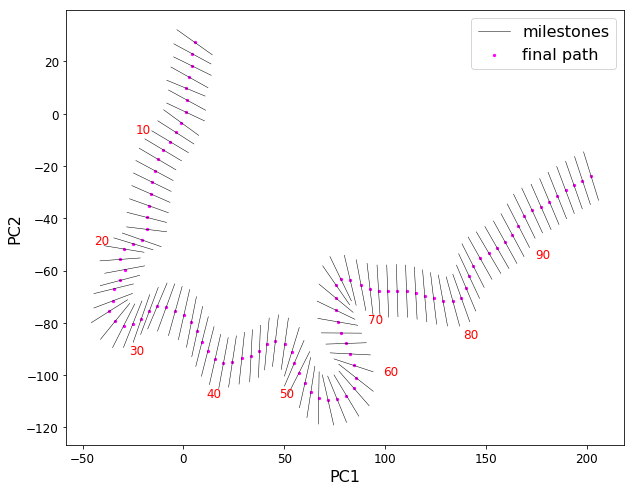

In [235]:
plt.figure(figsize=(10,8))
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params(labelsize=12)
plt.show()